###**0. Imports e conectar à Drive**

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image  #Python Imaging Library
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam  # usar isto qnd puder para alterar a learning rate

In [2]:
# correr esta célula apenas se o dataset estiver na drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Este pedaço de código é destinado a aceder à pasta do dataset, portanto pode ser diferente de user para user
%cd /content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset


##**Primeiro passo:** Extrair os ficheiros .png para entrarem no modelo, i.e., criar X_train e X_val

In [4]:
def number_of_images(X_type):

    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_images'
    files = os.listdir(root)

    return len(files)

In [5]:
# acessar às imagens e bboxes guardadas na drive, criadas a partir de outro código

def create_X_set_normalized(X_type):

    X_set = []
    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_images'
    length = number_of_images(X_type)

    for i in range(0, length):

      path = root + '/processed_' + X_type + 'image_' + str(i) + '.png'   # se calhar é melhor usar os.path.dir nestas situações e outras
      arr3 = cv2.imread(path)
      img_arr, _, _ = cv2.split(arr3)
      img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)   # é preciso normalizar de novo

      X_set.append(img_normalized)

    return np.array(X_set)

In [6]:
X_train = create_X_set_normalized('train')
X_val = create_X_set_normalized('valid')

In [7]:
X_train.shape

(1966, 384, 512)

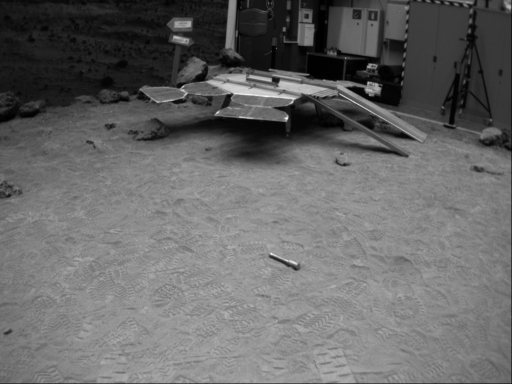

In [8]:
X = X_train[0]
x = cv2.merge([X,X,X])
pil_img = tf.keras.utils.array_to_img(x)
pil_img

##**Segundo passo:** Extrair as coordenadas das bounding boxes diretamente dos ficheiros csv, i.e., criar y_train e y_val

In [9]:
df_ytrain = pd.read_csv('./organized_data_gray/train/y_train.csv')
df_yval = pd.read_csv('./organized_data_gray/valid/y_val.csv')

In [10]:
def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [11]:
y_train = y_set(df_ytrain)
y_val = y_set(df_yval)

y_train[:2], y_val[:2]  # estes estão organizados devidamente, mas o X_train e X_val não estão

(array([[0.55348608, 0.67904656, 0.07315046, 0.0631929 ],
        [0.77792498, 0.5537694 , 0.13965087, 0.13414634]]),
 array([[0.70560578, 0.91962306, 0.08977556, 0.08536585],
        [0.95207294, 0.3248337 , 0.02743142, 0.03547672]]))

--- **Apenas a verificar se está a construir a bounding box corretamente** ---

In [12]:
# esta função executa o contrário da anterior: transforma uma bounding box com
#coordenadas em formato YOLO para uma bounding box em formato Albu

def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [13]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_set, y_set, index, new_img_path):

  y_set_Albu = bboxYOLO_to_Albu(y_set)

  X_arr = X_set[index]
  bbox = y_set_Albu[index]

  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  X_arr = cv2.merge([X_arr, X_arr, X_arr])   # para conseguir visualizar uma imagem a cinzento

  bbox_ = copy.deepcopy(bbox)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

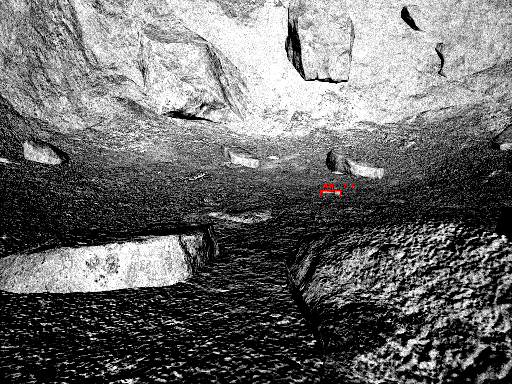

In [14]:
show_image_bbox(X_train, y_train, 900, 'new_dataset.png')

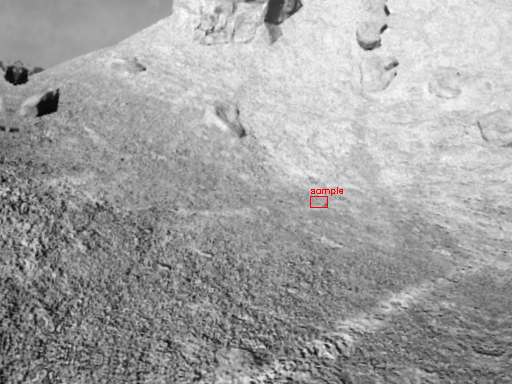

In [15]:
show_image_bbox(X_val, y_val, 200, 'new_dataset.png')

##**Terceiro passo:** Callbacks: CSVLogger, TensorBoard (ModelCheckpoint, neste caso, não será necessário)

In [16]:
!mkdir callbacks
!mkdir ./callbacks/tensorboard
!mkdir ./callbacks/checkpoints

mkdir: cannot create directory ‘callbacks’: File exists
mkdir: cannot create directory ‘./callbacks/tensorboard’: File exists
mkdir: cannot create directory ‘./callbacks/checkpoints’: File exists


In [27]:
# preparar o CSVLogger callback object

logger_path = './callbacks/graytraining_logger' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.log'  # tem gray na path do file para diferenciar
csv_logger = CSVLogger(logger_path,
                       append=True,
                       separator=',')

In [19]:
# preparar o ModelCheckpoint callback object

checkpoint_path = './callbacks/checkpoints/grayCkpt_{epoch:02d}_{val_loss:.05f}_.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [20]:
# preparar o TensorBoard callback object

%load_ext tensorboard

tboard_path = './callbacks/tensorboard/gray' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard = TensorBoard(log_dir = tboard_path,
                          histogram_freq=1)

## **Último passo**: Construir o modelo

In [ ]:
# L2 loss, não foi usado no modelo
"""
import tensorflow as tf

def custom_loss_with_l2_reg(lambda_value):
    def loss(y_true, y_pred):
        l2_loss = tf.add_n([tf.nn.l2_loss(w) for w in model.trainable_weights])
        return tf.reduce_mean(tf.square(y_true - y_pred)) + lambda_value * l2_loss
    return loss

lambda_value = 0.01
loss_fn = custom_loss_with_l2_reg(lambda_value)
"""

In [21]:
X_train.shape

(1966, 384, 512)

In [22]:
_, height, width = X_train.shape
model = Sequential([

    Conv2D(filters=16,kernel_size=(3,3),  input_shape = (height, width, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),

    Dense(4, activation='sigmoid')
])

In [25]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 94, 126, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       1

In [ ]:
"""
# ---- correr apenas quando já tiver algo treinado ----
# esta célula serve para encontrar qual o ficheiro que contém a menor loss

highest_epoch = 0
lowest_val_loss = 0

for file in os.listdir('./callbacks/checkpoints'):

    epoch_ = file.split('_')[1]
    val_loss_ = file.split('_')[2]

    if int(epoch_) > highest_epoch :
       highest_epoch = int(epoch_)
       lowest_val_loss = float(val_loss_)

if highest_epoch < 10:
   highest_epoch = '0' + str(highest_epoch)

else:
  highest_epoch = str(highest_epoch)

lowest_val_loss = f'{lowest_val_loss:.05f}'

print(highest_epoch, lowest_val_loss)
"""

18 0.01605 3
7/7 - 10s - loss: 0.0169 - accuracy: 0.4491 - 10s/epoch - 1s/step


In [ ]:
"""
# esta função vai criar a path de um dos model checkpoints que estão na pasta 'checkpoints'

def path_checkpoint(epoch, val_loss):
    path = './callbacks/checkpoints/Ckpt_' + epoch + '_' + val_loss + '_.h5'
    return path


model.load_weights(path_checkpoint(highest_epoch, lowest_val_loss))
loss, acc = model.evaluate(X_val, y_val, verbose=2)
"""

7/7 - 8s - loss: 0.0169 - accuracy: 0.4491 - 8s/epoch - 1s/step


In [ ]:
model.fit(X_train,
          y_train,
          epochs = 20,
          batch_size = 25,
          validation_data = (X_val, y_val),
          callbacks = [checkpoint, csv_logger, tensorboard])

Epoch 1/20
79/79 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.4959
Epoch 1: val_loss improved from inf to 0.02100, saving model to ./callbacks/checkpoints/grayCkpt_01_0.02100_.h5
79/79 [==============================] - 474s 6s/step - loss: 0.0703 - accuracy: 0.4959 - val_loss: 0.0210 - val_accuracy: 0.5139
Epoch 2/20
79/79 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.5041
Epoch 2: val_loss did not improve from 0.02100
79/79 [==============================] - 468s 6s/step - loss: 0.0173 - accuracy: 0.5041 - val_loss: 0.0231 - val_accuracy: 0.5046
Epoch 3/20
79/79 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.5214
Epoch 3: val_loss improved from 0.02100 to 0.01924, saving model to ./callbacks/checkpoints/grayCkpt_03_0.01924_.h5
79/79 [==============================] - 465s 6s/step - loss: 0.0166 - accuracy: 0.5214 - val_loss: 0.0192 - val_accuracy: 0.5046
Epoch 4/20
79/79 [==============================] - E

In [ ]:
y_pred = model.predict(X_val)  # ver se o dropout está desativado
y_pred

7/7 [==============================] - 21s 3s/step


array([[0.51021206, 0.49367118, 0.27555647, 0.2817035 ],
       [0.5994054 , 0.4648362 , 0.08249372, 0.06146891],
       [0.47090915, 0.48713136, 0.11859687, 0.10930217],
       [0.5531395 , 0.40775502, 0.153882  , 0.13253002],
       [0.45878297, 0.38997746, 0.1594643 , 0.17063251],
       [0.48544613, 0.45456198, 0.18074511, 0.17214127],
       [0.625651  , 0.48722327, 0.16829078, 0.13989328],
       [0.49567917, 0.47236234, 0.12540606, 0.09143424],
       [0.4384517 , 0.52512556, 0.1788569 , 0.17165378],
       [0.5345111 , 0.57055974, 0.10555327, 0.08322162],
       [0.4230261 , 0.46696225, 0.02257816, 0.01280884],
       [0.6079107 , 0.6099587 , 0.04302276, 0.02851802],
       [0.5211548 , 0.5214902 , 0.03949403, 0.02668707],
       [0.53188527, 0.55130213, 0.23551966, 0.21274936],
       [0.622435  , 0.4608702 , 0.10752714, 0.07562293],
       [0.62851214, 0.54004824, 0.03300073, 0.02480721],
       [0.45791912, 0.45197988, 0.05248676, 0.04563966],
       [0.62140656, 0.50406986,

In [ ]:
y_pred_train = model.predict(X_train)

62/62 [==============================] - 154s 2s/step


In [ ]:
%tensorboard --logdir=./callbacks/tensorboard

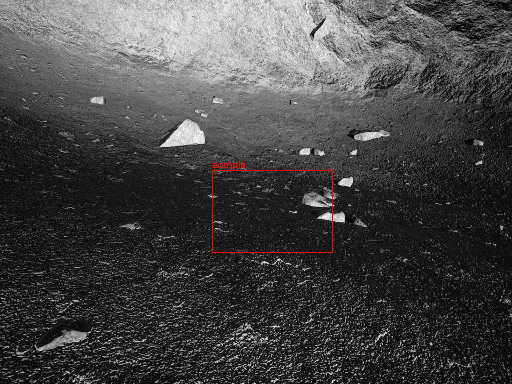

In [ ]:
show_image_bbox(X_val, y_pred, 13, 'transformed.png')

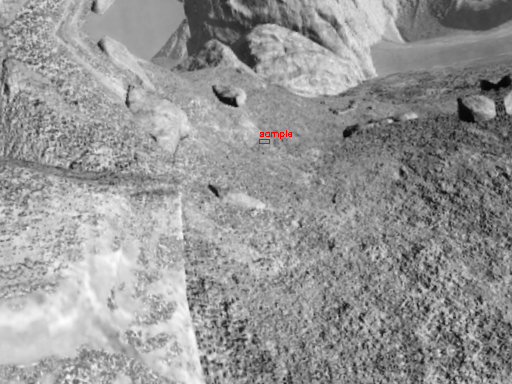

In [ ]:
show_image_bbox(X_train, y_pred_train, 1910, 'transformed.png')

##**Oitavo passo:** Intersection over union (IoU), para avaliar de uma forma mais correta o modelo

**Intersection over union: metric to measure localization accuracy**

In [ ]:
def intersection_over_union(bboxA, bboxB):

    bboxes = bboxYOLO_to_Albu([bboxA, bboxB])
    bbox1 = bboxes[0]
    bbox2 = bboxes[1]

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bbox1[0], bbox2[0])
    ymin = max(bbox1[1], bbox2[1])
    xmax = min(bbox1[2], bbox2[2])
    ymax = min(bbox1[3], bbox2[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = bbox1_area + bbox2_area - intersection_area

    IoU = intersection_area / union_area

    return IoU

In [ ]:
# uma função que pode dar informações rápidas e talvez relevantes sobre a IoU

def iou_info(y_set, y_pred):

  iou_sum = 0
  iou_above_0 = []

  for i in range(len(y_set)):
      iou = intersection_over_union(y_set[i], y_pred[i])

      if iou > 0:
        iou_above_0.append(i)

      iou_sum += iou

  pct_iou_mean = iou_sum / len(iou_above_0) * 100
  pct_intersection = len(iou_above_0) / y_set.shape[0] * 100

  return pct_iou_mean, len(iou_above_0), pct_intersection, iou_above_0 #.shape[0]

In [ ]:
print(' - for y_val and y_pred:'
      '\n mean % of the area intersected in all intersections:', iou_info(y_val, y_pred)[0],
      '\n number of intersections:', iou_info(y_val, y_pred)[1],
      '\n percentage of intersections:', iou_info(y_val, y_pred)[2],
      '\n indexes of images with intersections:', iou_info(y_val, y_pred)[3])

 - for y_val and y_pred:
 mean of the area intersected in all intersections: 2.6867652513159372 
 number of intersections: 27 
 percentage of intersections: 12.5 
 indexes of images with intersections: [8, 13, 26, 29, 30, 36, 41, 44, 45, 49, 96, 101, 114, 115, 117, 119, 124, 129, 132, 133, 134, 136, 144, 149, 163, 181, 186]


In [ ]:
print(' - for y_train and y_pred_train:'
      '\n mean of the area intersected in all intersections:', iou_info(y_train, y_pred_train)[0],
      '\n number of intersections:', iou_info(y_train, y_pred_train)[1],
      '\n percentage of intersections:', iou_info(y_train, y_pred_train)[2],
      '\n indexes of images with intersections:', iou_info(y_train, y_pred_train)[3])

 - for y_train and y_pred_train:
 mean of the area intersected in all intersections: 4.124633918692658 
 number of intersections: 568 
 percentage of intersections: 28.891149542217704 
 indexes of images with intersections: [0, 1, 2, 4, 10, 19, 26, 31, 32, 36, 37, 44, 45, 47, 49, 54, 55, 57, 58, 59, 60, 61, 70, 72, 74, 79, 80, 82, 86, 90, 91, 95, 98, 100, 101, 102, 105, 107, 108, 109, 110, 111, 114, 117, 118, 119, 121, 123, 125, 129, 131, 133, 134, 135, 140, 141, 144, 145, 146, 149, 150, 151, 152, 159, 160, 161, 163, 164, 165, 166, 169, 179, 180, 181, 188, 193, 196, 199, 201, 202, 204, 211, 212, 214, 215, 217, 220, 224, 225, 227, 230, 232, 233, 236, 237, 238, 240, 241, 242, 248, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 264, 265, 271, 273, 274, 275, 277, 278, 280, 281, 285, 287, 291, 294, 296, 297, 298, 301, 302, 304, 308, 310, 312, 315, 320, 321, 327, 329, 330, 331, 333, 335, 336, 338, 339, 341, 342, 343, 348, 349, 350, 355, 357, 358, 359, 364, 374, 375, 377, 378, 379, 385, 38

##**Valores relevantes para o relatório:**

**Pontos importantes a guardar em cada teste**:
- Nº de imagens usadas
- Shape das imagens usadas
- Normalização / standardização das imagens (como foram normalizadas ou standardizadas)
- Loss function usada
- Test loss (com o X_val)
- Optimizer usado
- Nº de epochs
- batch_size
- Função IoU (iou_mean e iou_above_0) para o val e para o train também
- Transformações aplicadas às imagens

**Em relação às camadas do modelo:**
O mais simples é mostrar o modelo completo, mas as seguintes são todas informações a reter
- Conv2D: nº de filters em cada, kernel_size, activation_function
- MaxPooling2D: pool_size
- Dropout: probabilidade de 0 a 1 usada e quantas usadas
- Dense: quantos neurónios na dense layer, activation_function

In [ ]:
df_logs = pd.read_csv(logger_path)
df_logs

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.468697,0.074102,0.484848,0.054245
1,1,0.494078,0.013680,0.484848,0.032379
2,2,0.532995,0.010967,0.560606,0.029631
3,3,0.516074,0.009973,0.530303,0.027684
4,4,0.536379,0.009247,0.515152,0.021846
...,...,...,...,...,...
75,15,0.936681,0.002513,0.460000,0.016722
76,16,0.921397,0.002221,0.540000,0.016531
77,17,0.938865,0.002296,0.500000,0.016045
78,18,0.945415,0.002628,0.500000,0.016471
